In [1]:
"""
   Copyright (C) 2024 ETH Zurich. All rights reserved.
   Author: Sergei Vostrikov, ETH Zurich
           Cedric Hirschi, ETH Zurich
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at
       http://www.apache.org/licenses/LICENSE-2.0
   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

   SPDX-License-Identifier: Apache-2.0
"""

'\n   Copyright (C) 2024 ETH Zurich. All rights reserved.\n   Author: Sergei Vostrikov, ETH Zurich\n           Cedric Hirschi, ETH Zurich\n   Licensed under the Apache License, Version 2.0 (the "License");\n   you may not use this file except in compliance with the License.\n   You may obtain a copy of the License at\n       http://www.apache.org/licenses/LICENSE-2.0\n   Unless required by applicable law or agreed to in writing, software\n   distributed under the License is distributed on an "AS IS" BASIS,\n   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n   See the License for the specific language governing permissions and\n   limitations under the License.\n\n   SPDX-License-Identifier: Apache-2.0\n'

# If you are not familiar with Jupyter Notebooks, please first check online tutorials such as https://realpython.com/jupyter-notebook-introduction/#creating-a-notebook

In [2]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

### Test of Matplotlib Widget Backend

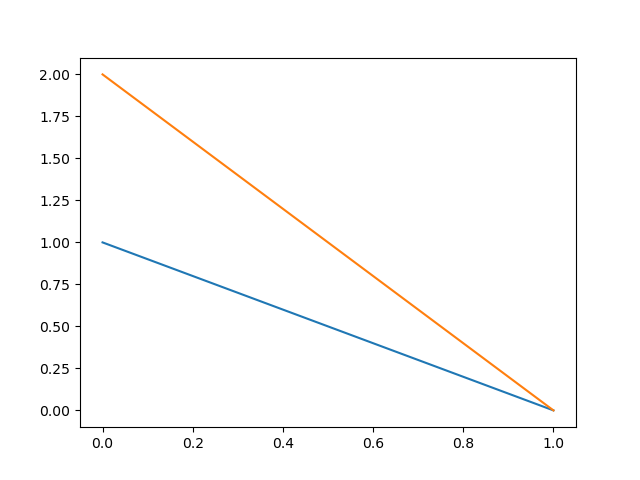

In [3]:
import matplotlib.pyplot as plt

plt.plot([[1, 2], [0, 0]])

#### If you do not see a figure above,  try to restart the kernel.
#### If it does not help, check the installation of **ipympl** library.

## Run WULPUS GUI Demo

## Prepare TX/RX configurations for WULPUS

In [4]:
np.arange(16)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

### Either use the dedicated TX//RX GUI

In [5]:
# import wulpus.rx_tx_conf_gui as conf_gui

# # Generate Transmit/Receive configs using the GUI
# conf_gen = conf_gui.WulpusRxTxConfigGenGUI()

# display(conf_gen)

### Or use the Python API

#### By configuring the TX/RX channels manually

In [6]:
from wulpus.rx_tx_conf_pro import WulpusProRxTxConfigGen

# COMMENT THE CODE IN THIS CELL WHEN USING TX/RX GUI 

# TX and RX active channels IDs
conf_gen = WulpusProRxTxConfigGen()

# # The first array is a set of TX chanels, the second one - RX.
conf_gen.add_config([i for i in range(16)], [i for i in range(15)])

#### Or loading the the TX/RX config from the file

In [7]:
import wulpus.rx_tx_conf_gui as conf_gui

# # load configurations directly from a file

# conf_gen = conf_gui.WulpusRxTxConfigGenGUI()
# tx_confs = conf_gen.with_file("tx_rx_configs.json").get_tx_configs()
# rx_confs = conf_gen.with_file("tx_rx_configs.json").get_rx_configs()

## Prepare Ultrasound Subsystem configuration for WULPUS
 (Manually or by loading it from a file)

In [8]:
from wulpus.uss_conf_pro import WulpusProUssConfig, PGA_GAIN
from wulpus.uss_conf_gui_pro import WulpusProUssConfigGUI

# Get TX/RX configurations
tx_confs = conf_gen.get_tx_configs()
rx_confs = conf_gen.get_rx_configs()

print('TX config: ', np.binary_repr(tx_confs[0]))
print('RX config: ', np.binary_repr(rx_confs[0]))

# Create US subsystem configuration
uss_conf = WulpusProUssConfig(num_acqs=100,
                           dcdc_turnon=100,
                           start_hvmuxrx=500,
                           meas_period=321965,
                           num_txrx_configs=len(tx_confs),
                           tx_configs=tx_confs,
                           rx_configs=rx_confs,
                           rx_gain=PGA_GAIN[12],
                           trans_freq=2250000,
                           num_pulses=2,
                           sampling_freq=8000000)

# Modify US subsystem configuration using the GUI
uss_conf = WulpusProUssConfigGUI(uss_conf)

# Or Load settings from a file
# uss_conf.with_file('uss_config.json')

print("Gain dB: ", uss_conf.rx_gain)

display(uss_conf)

TX config:  1111111111111111
RX config:  111111111111111
Gain dB:  3.5


WulpusProUssConfigGUI(children=(HBox(children=(VBox(children=(HTML(value='<b>Measurement settings</b>'), Bound…

### Initialize a connection

We initialize a `WulpusDongle` object here such that it can run independently from the GUI.

In [9]:
from wulpus.dongle import WulpusDongle

# Create a dongle object
dongle = WulpusDongle()

### Run GUI 
(Check the WULPUS user manual (chapter 3 and 4) for more information)

Fixed Gain Mode


WulpusGuiSingleCh(children=(VBox(children=(HBox(children=(VBox(children=(Checkbox(value=True, description='Sho…

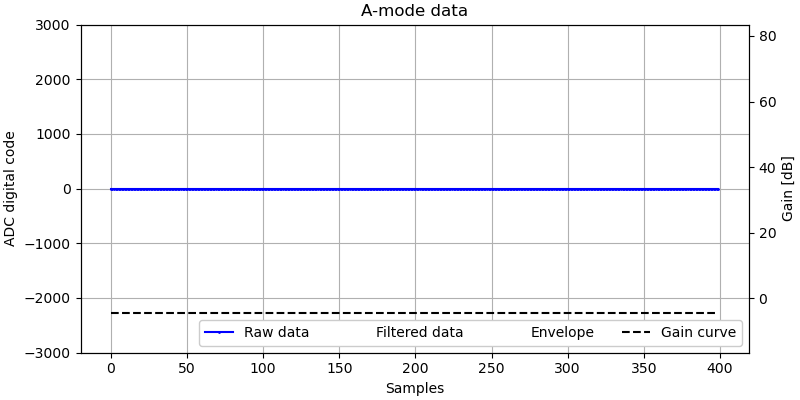

In [10]:
%matplotlib widget
from wulpus.gui import WulpusGuiSingleCh

# Create a GUI
try:
    # Check if the GUI object already exists
    gui
except NameError:
    # Does not exist. Create a new GUI
    gui = WulpusGuiSingleCh(dongle, uss_conf, max_vis_fps = 20)
else:
    # Exist. First, close the COM port and then create a new GUI
    if gui.port_opened:
        gui.com_link.__ser__.close()
    gui = WulpusGuiSingleCh(dongle, uss_conf, max_vis_fps = 20)

display(gui)

## Loading and interpreting the saved data

The data is saved in a `.npz` file. This is a compressed file format that can be used with the `numpy` library.

Explore an example below to learn how to load and interpret the data.

In [10]:
# Data can be loaded as easy as:
data = np.load('./examples/data_0.npz')

# The keys of the data are:
print('Keys:', data.files)

Keys: ['data_arr', 'acq_num_arr', 'tx_rx_id_arr']


The structure is a dictionary with the length `num_acquisitions` (Number of acquisitions) and consists of the following keys:

**data_arr:** This column actually contains the data, each of length `num_samples` (Number of samples). This can be seen as data for one acquisition.

**acq_num_arr:** The sequential number for each acquisition. MSP430 increments this number by 1 every new acquisition, starting from zero. If one number is missing (a step is larger than one), then this acquisition got dropped during the BLE transmission.

**tx_rx_id_arr:** The TX/RX configuration ID for the acquisition. This ids  are the same as the ones in the `Active RX ID` dropdown menu in the GUI (the same as Config field in the RX/TX config GUI).

In [11]:
# The shape of the data is:
print('Data shape:', data['data_arr'].shape)

# The unique IDs of the active channels are:
print('Unique IDs:', np.unique(data['tx_rx_id_arr']))

Data shape: (400, 100)
Unique IDs: [0]


In this example, we have 100 acquisitions, each containing 400 samples. The WULPUS system was connected to the 8 channels of the linear array transducer (2.25 MHz), placed on the forearm, while the proband was performing periodic hand gestures. There was only one TX/RX configuration programmed (config id = 0). With this configuration, 8 channel were used at both transmit and receive. The data was acquired with the settings saved in the files `./examples/tx_rx_configs.json` and `./examples/uss_config.json`.

Since the `data_arr` is a bit awkward to use in this form (`(400, 100)`), we transpose it to `(100, 400)`.

In [15]:
# Transpose the data such that we can index via time
data_meas = data['data_arr'].T

# The shape of the data is:
print('Data shape:', data_meas.shape)

Data shape: (100, 400)


The data can then be easily used further, for example to just make a plot of one acquisition. 

As a general example, we show how to select the data only for the TX/RX config with an ID **n = 0**.

In [16]:
channel_id = 0

data_sel = data_meas[data['tx_rx_id_arr'] == channel_id, :]

In [17]:
data_sel.shape

(100, 400)


We visualize the data with `matplotlib` and `ipywidgets`.
By interacting with the slider, a user can see the data over time.

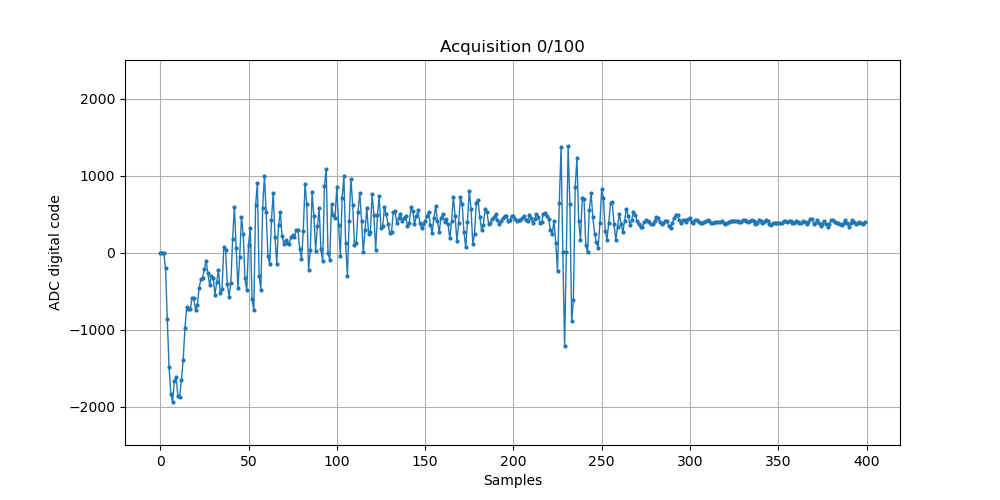

interactive(children=(IntSlider(value=10, description='frame', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.visualize(frame)>

In [18]:
plt.figure(figsize=(10, 5))
plot_data = plt.plot(data_sel[0], linestyle='-', marker='o', linewidth=1, markersize=2)
plt.ylim(-2500, 2500)
plt.title(f'Acquisition 0/{data_sel.shape[0]}')
plt.xlabel('Samples')
plt.ylabel('ADC digital code')
plt.grid()
plt.show()

def visualize(frame):
    plot_data[0].set_ydata(data_sel[frame])
    plt.title(f'Acquisition {frame}/{data_sel.shape[0]}')
    plt.draw()

widgets.interact(visualize, frame=widgets.IntSlider(min=0, max=data_sel.shape[0]-1, step=1, value=10))

A user can further perform band-pass filtering and application-specific processing of the raw data.